In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
# Load the trader dataset from Hyperliquid
trader_df = pd.read_csv("historical_data.csv")

# Load the Bitcoin Fear and Greed Index dataset
sentiment_df = pd.read_csv("fear_greed_index.csv")


In [3]:
# Convert sentiment 'date' column to datetime format and extract only the date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Rename 'classification' column to 'Sentiment' for clarity
sentiment_df.rename(columns={'classification': 'Sentiment'}, inplace=True)


In [4]:
# Convert trader data timestamp to datetime format
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Extract the date from timestamp to match with sentiment data
trader_df['date'] = trader_df['Timestamp IST'].dt.date


In [5]:
# Merge trader and sentiment data on the 'date' column
# This combines both datasets so we can analyze performance vs market sentiment
merged_df = pd.merge(trader_df, sentiment_df[['date', 'Sentiment']], how='left', on='date')

# Remove rows where sentiment is missing (e.g., weekends or holidays)
merged_df = merged_df.dropna(subset=['Sentiment'])


In [6]:
# Convert numerical columns to proper data types
merged_df['Closed PnL'] = pd.to_numeric(merged_df['Closed PnL'], errors='coerce')
merged_df['Size USD'] = pd.to_numeric(merged_df['Size USD'], errors='coerce')

# Create new feature: PnL per dollar invested
merged_df['pnl_per_usd'] = merged_df['Closed PnL'] / merged_df['Size USD']

# Create binary feature: whether the trade was profitable
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0


In [7]:
# Group data by sentiment and calculate average metrics
summary_by_sentiment = merged_df.groupby('Sentiment').agg({
    'Closed PnL': ['mean', 'std'],      # Mean and standard deviation of PnL
    'pnl_per_usd': 'mean',              # Average profit per dollar
    'Size USD': 'mean',                 # Average trade size
    'is_profitable': 'mean'             # Proportion of profitable trades
}).round(3)

# Flatten multi-index columns for easier access
summary_by_sentiment.columns = ['_'.join(col).strip() for col in summary_by_sentiment.columns.values]
summary_by_sentiment.reset_index(inplace=True)


In [8]:
# Analyze average PnL per symbol under each sentiment condition
symbol_sentiment = merged_df.groupby(['Coin', 'Sentiment'])['Closed PnL'].mean().reset_index()


Visualizations with Comments

C:\Users\kbhas\AppData\Local\Temp\ipykernel_49752\8755758.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Closed PnL_mean', data=summary_by_sentiment, palette='viridis')


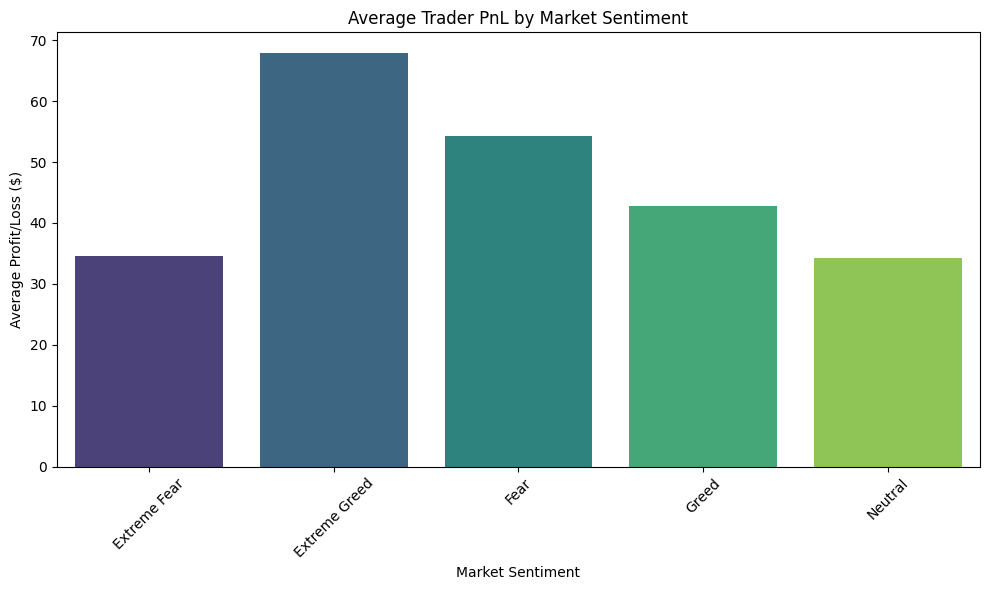

In [9]:
# Plot average PnL for each market sentiment type
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Closed PnL_mean', data=summary_by_sentiment, palette='viridis')
plt.title('Average Trader PnL by Market Sentiment')
plt.ylabel('Average Profit/Loss ($)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\kbhas\AppData\Local\Temp\ipykernel_49752\1323293792.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='is_profitable_mean', data=summary_by_sentiment, palette='coolwarm')


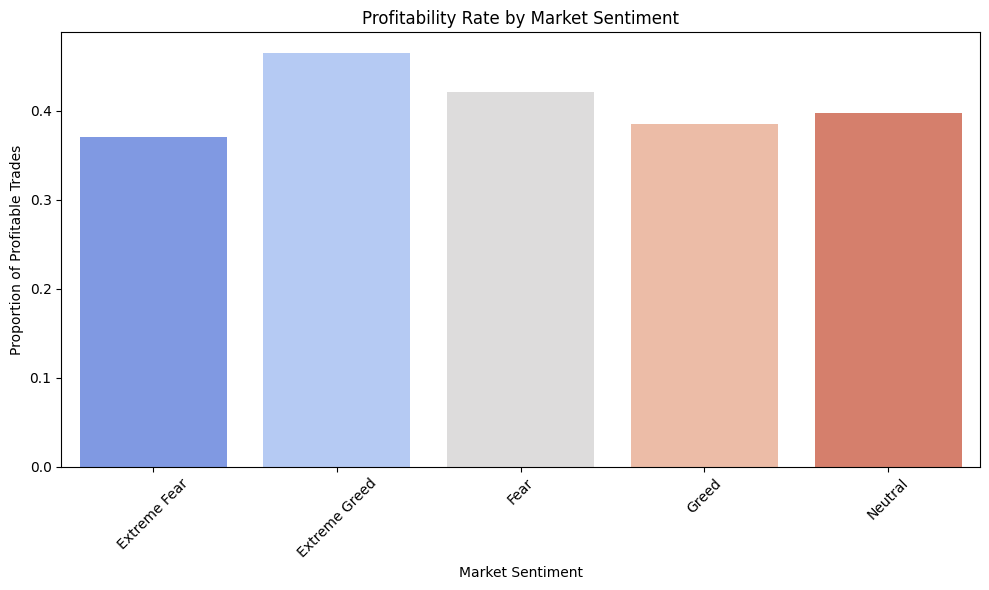

In [10]:
# Plot proportion of profitable trades across sentiments
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='is_profitable_mean', data=summary_by_sentiment, palette='coolwarm')
plt.title('Profitability Rate by Market Sentiment')
plt.ylabel('Proportion of Profitable Trades')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\kbhas\AppData\Local\Temp\ipykernel_49752\2930785950.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='pnl_per_usd', data=merged_df, palette='crest')


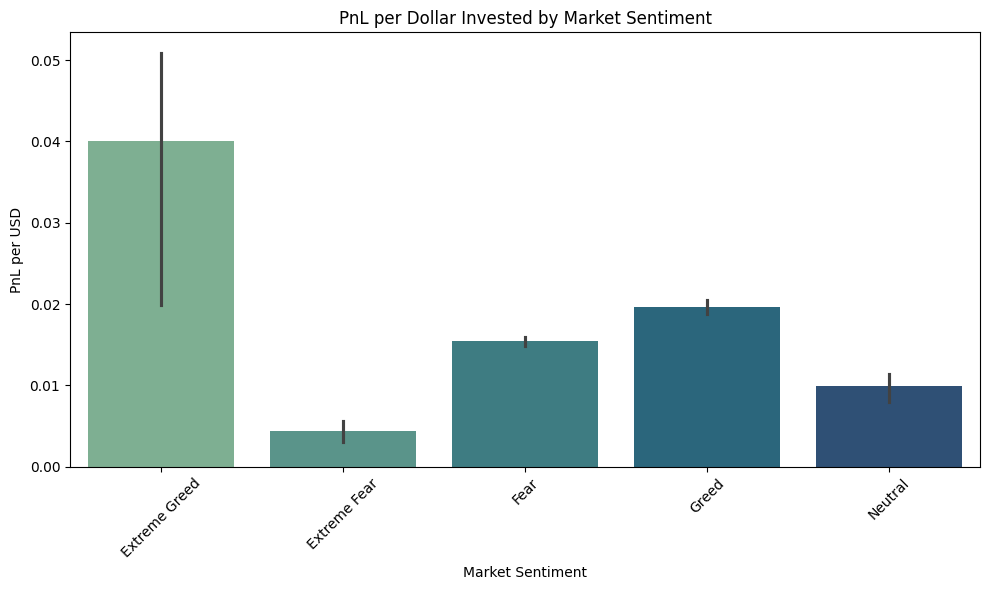

In [11]:
# Plot PnL per USD across market sentiments
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='pnl_per_usd', data=merged_df, palette='crest')
plt.title('PnL per Dollar Invested by Market Sentiment')
plt.ylabel('PnL per USD')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


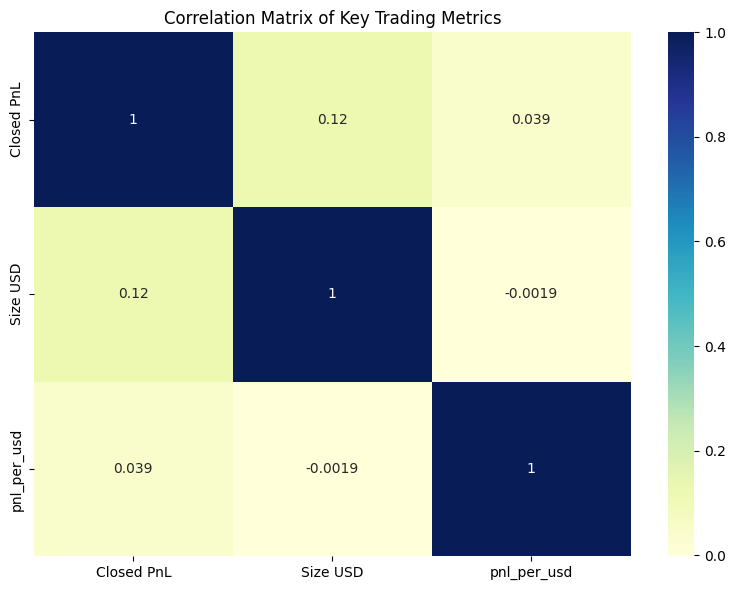

In [12]:
# Plot correlation heatmap between key numerical features
plt.figure(figsize=(8, 6))
corr = merged_df[['Closed PnL', 'Size USD', 'pnl_per_usd']].corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix of Key Trading Metrics')
plt.tight_layout()
plt.show()


Export Processed Data

In [13]:
# Export summaries and full merged data to CSVs for further use or submission
summary_by_sentiment.to_csv("sentiment_summary.csv", index=False)
symbol_sentiment.to_csv("symbol_sentiment_pnl.csv", index=False)
merged_df.to_csv("merged_trader_sentiment_data.csv", index=False)
